In [1]:
import tensorflow as tf
import librosa
import numpy as np
import IPython.display as ipd
import os
import pyaudio
import wave
import matplotlib.pyplot as plt

## Loading samples

In [2]:
data = np.load('data/merged.npz')
X = data['sample']
Y = data['label']
X.shape

(4901, 20, 65, 1)

## Split into validation and train data

In [3]:
X_val = np.append(X[:120], X[-120:], axis=0)
X_train = X[120:-120]
Y_val = np.append(Y[:120], Y[-120:], axis=0)
Y_train = Y[120:-120]
X_val.shape

(240, 20, 65, 1)

## Preparing dataset

In [4]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).repeat().shuffle(len(X_val)).batch(32)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).repeat().shuffle(len(X_train)).batch(256)

## Preparing model

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', input_shape=(20, 65, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [6]:
sgd = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

In [7]:
# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer=sgd,
#               metrics=['accuracy'])
model.compile(optimizer=sgd,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train model

In [23]:
model.fit(train_dataset, epochs=, validation_data=val_dataset, steps_per_epoch=2, validation_steps=4)

Train for 2 steps, validate for 4 steps
Epoch 1/5
2/2 [==============================] - 2s 812ms/step - loss: 0.5525 - accuracy: 0.9414 - val_loss: 0.5637 - val_accuracy: 0.8750
Epoch 2/5
2/2 [==============================] - 2s 772ms/step - loss: 0.5489 - accuracy: 0.9297 - val_loss: 0.5689 - val_accuracy: 0.8672
Epoch 3/5
2/2 [==============================] - 2s 772ms/step - loss: 0.5446 - accuracy: 0.9473 - val_loss: 0.5631 - val_accuracy: 0.8672
Epoch 4/5
2/2 [==============================] - 2s 776ms/step - loss: 0.5481 - accuracy: 0.9395 - val_loss: 0.5632 - val_accuracy: 0.8594
Epoch 5/5
2/2 [==============================] - 2s 766ms/step - loss: 0.5432 - accuracy: 0.9492 - val_loss: 0.5437 - val_accuracy: 0.9062


## Obtaining answer

#### Recording sample

In [56]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
RECORD_SECONDS = 1.5
WAVE_OUTPUT_FILENAME = "output.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording ")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("* done recording ")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording 
* done recording 


#### Sample processing

In [57]:
x, sr = librosa.load(r"output.wav")
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=len(x)//64, n_mfcc=20)
# mfcc = mfcc.flatten()np.shape/(X_other_copy)
print(mfcc.shape)

ipd.Audio(r"output.wav", rate=sr)
# "WAVE_OUTPUT_FILENAME"
#r"audiobooks/data/ru_open_stt/private_buriy_audiobooks_2/0/1d/07921cf11da9.wav"

(20, 65)


#### Model testing

In [59]:
# model.predict(X.values[2200].reshape(1, X.shape[1])
model.predict(mfcc.reshape(1, 20, 65, 1))

array([[0.2900529, 0.7099471]], dtype=float32)

#### Saving model

In [27]:
model.save('models\\64_hop_20_nmfcc_CNN_v_5.h5')

In [53]:
mfcc = X_val[-4].reshape(20, 65)

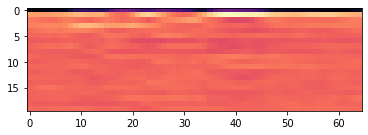

In [13]:
plt.imshow(X[12].reshape(20, 65), cmap='magma')

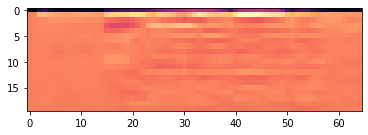

In [58]:
plt.imshow(mfcc, cmap='magma')

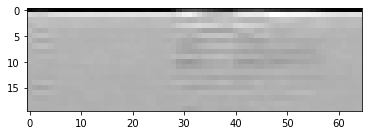

In [38]:
plt.imshow(mfcc, cmap='gray')

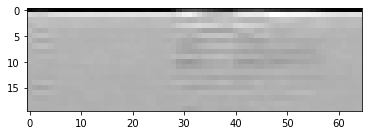

In [39]:
plt.imshow(mfcc, cmap='gray')